In [133]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [134]:
data = pd.read_csv("AirPassengers.csv")
display(data.head(20))

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [136]:
data['Month'] = pd.to_datetime(data['Month'], format="%Y.%m.")

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [138]:
data.set_index('Month', inplace=True)

In [139]:
data.index.is_monotonic_increasing

True

Оставим только данные с 1952 по 1957 год включительно

In [140]:
data1 = data['1952':'1957']
print(data1.index.min(), data1.index.max())

1952-01-01 00:00:00 1957-12-01 00:00:00


Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.

In [141]:
decomposed = seasonal_decompose(data1['#Passengers'])

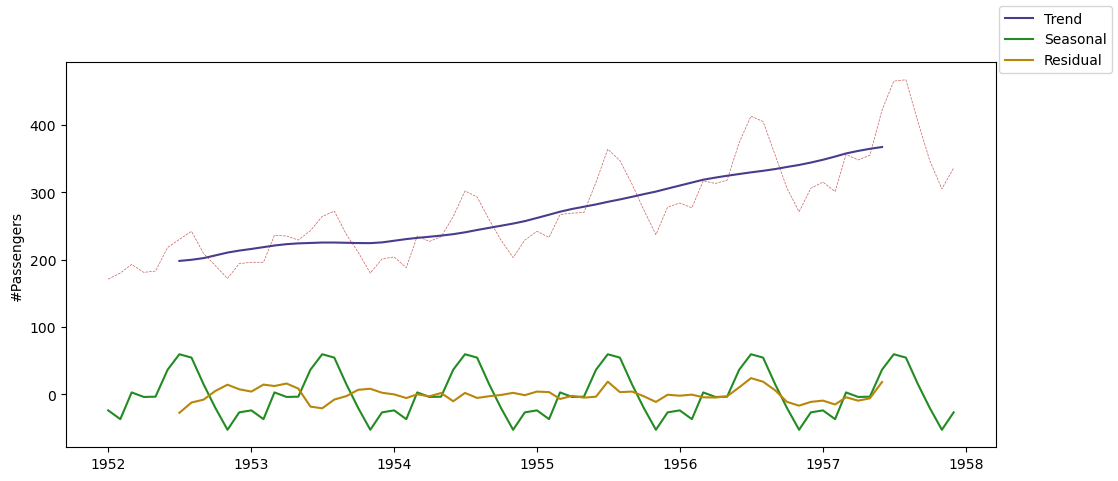

In [142]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(data1['#Passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('#Passengers')

fig.legend();

Есть ли тренд?
- На графике видно, что тренд имеется

Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?
- Сезонность ежегодная

Является ли ряд стационарным и почему?
- Ряд нестационарный, поскольку есть тренд

In [143]:
data1['#Passengers'].shape

(72,)

Постройте график, чтобы оценить автокорреляцию и сделайте выводы

In [144]:
acf = sm.tsa.acf(data1['#Passengers'])
acf.shape

(19,)

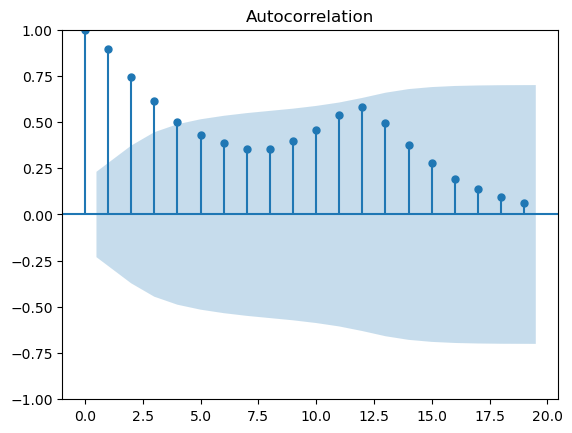

In [145]:
fig = tsaplots.plot_acf(data1['#Passengers'])
plt.show()

У какого сдвига самая высокая автокорреляция?
- Самая большая автокорреляция приходится на отсечку 1

Подтверждаются ли выводы о наличии тренда графиком автокорреляции?
- Автокорреляция на графике выше нуля, что говорит о наличии положительного тренда

- На отсечку 12 приходится большая автокорреляция, во временном ряду имеется ежегодная сезонность

Подготовьте данные к обучению линейной модели

Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)

In [146]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    
    for i in range(1, max_lag + 1):
        data[f'lag_{i}'] = data['#Passengers'].shift(i)
        
    data['rolling_mean'] = data['#Passengers'].rolling(rolling_mean_size).mean()
    data['rolling_mean'] = data['rolling_mean'].shift(1)
    
    return data

Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.

Удалите наблюдения с пропусками в новых переменных.

Разделите данные на признаки и целевую переменную.

Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.

In [147]:
data_with_features = make_features(data1.copy(), 10, 3)
data_with_features.head()

,#Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
Month,,,,,,,,,,,,,,,
1952-01-01,171,1952,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-02-01,180,1952,2,1,171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-03-01,193,1952,3,1,180.0,171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-04-01,181,1952,4,2,193.0,180.0,171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.333333
1952-05-01,183,1952,5,2,181.0,193.0,180.0,171.0,NaN,NaN,NaN,NaN,NaN,NaN,184.666667


In [148]:
data_with_features = data_with_features.dropna()

In [149]:
target_variable = "#Passengers"
features = data_with_features.drop(target_variable, axis=1)
target = data_with_features[target_variable]

train_features, test_features, train_target, test_target = train_test_split(features, target, shuffle=False, test_size=0.2)

Обучите линейную модель машинного обучения и оцените ее качество

Обучите линейную модель на обучающей части данных.

Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика выше 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.

Визуализируйте реальный временной ряд и прогнозные значения. 

In [150]:
scaler = StandardScaler().fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

model = LinearRegression()
model.fit(train_features_norm, train_target)

train_prediction = pd.Series(model.predict(train_features_norm))
train_prediction.index = train_features.index
test_prediction = pd.Series(model.predict(test_features_norm))
test_prediction.index = test_features.index

print("MAE обучающей выборки:", mean_absolute_error(train_target, train_prediction))
print("MAE тестовой выборки: ", mean_absolute_error(test_target, test_prediction))

MAE обучающей выборки: 11.517282982944291
MAE тестовой выборки:  14.646608461713443


Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год

Возьмите из источника необходимый срез данных.

Подготовьте данные к прогнозированию.

Добавьте признаки с помощью реализованной ранее функции.

Удалите наблюдения с пропусками.

Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.

 Отделите целевую переменную от признаков.

Постройте прогноз с помощью обученной ранее линейной модели.

Рассчитайте значение метрики качества на отложенной выборке.

Визуализируйте реальный временной ряд и прогнозные значения.

Значение метрики MAE на отложенной выборке должно быть не более 35.

In [151]:
data_delayed = data['1957':'1960']
print(data_delayed.index.min(), data_delayed.index.max())

1957-01-01 00:00:00 1960-12-01 00:00:00


In [152]:
data_delayed_with_features = make_features(data_delayed.copy(), 10, 3)
data_delayed_with_features.head()

,#Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
Month,,,,,,,,,,,,,,,
1957-01-01,315,1957,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-02-01,301,1957,2,1,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-01,356,1957,3,1,301.0,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-04-01,348,1957,4,2,356.0,301.0,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,324.0
1957-05-01,355,1957,5,2,348.0,356.0,301.0,315.0,NaN,NaN,NaN,NaN,NaN,NaN,335.0


In [153]:
data_delayed_with_features = data_delayed_with_features.dropna()

In [154]:
data_delayed_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 1957-11-01 to 1960-12-01
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   #Passengers   38 non-null     int64  
 1   year          38 non-null     int64  
 2   month         38 non-null     int64  
 3   quarter       38 non-null     int64  
 4   lag_1         38 non-null     float64
 5   lag_2         38 non-null     float64
 6   lag_3         38 non-null     float64
 7   lag_4         38 non-null     float64
 8   lag_5         38 non-null     float64
 9   lag_6         38 non-null     float64
 10  lag_7         38 non-null     float64
 11  lag_8         38 non-null     float64
 12  lag_9         38 non-null     float64
 13  lag_10        38 non-null     float64
 14  rolling_mean  38 non-null     float64
dtypes: float64(11), int64(4)
memory usage: 4.8 KB


In [155]:
target_variable = "#Passengers"
features = data_delayed_with_features.drop(target_variable, axis=1)
target = data_delayed_with_features[target_variable]

In [156]:
features_norm = scaler.transform(features)
prediction = pd.Series(model.predict(features_norm))
prediction.index = features.index

print("MAE отложенной выборки: ", mean_absolute_error(target, prediction))

MAE отложенной выборки:  24.904373629021997


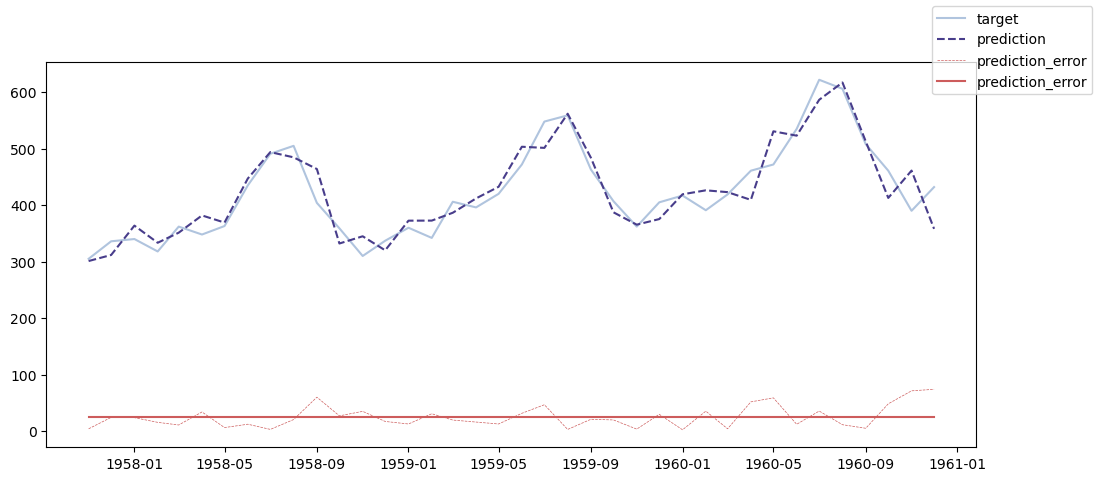

In [157]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(target - prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = target.index

ax.plot(target, c='lightsteelblue', label='target')
ax.plot(prediction, c='darkslateblue', label='prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();